In [567]:
import warnings; warnings.simplefilter('ignore')
# /usr/bin/python
from boto.mturk.connection import MTurkConnection
from boto.mturk.question import ExternalQuestion
from dateutil.parser import *
from boto.mturk.question import HTMLQuestion
import numpy as np
import datetime, hashlib, boto, os, pymongo, json, pandas

In [568]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [569]:
# conect to the mongodb
data = json.load(open('../credentials/auth.json'))
mongo_tunnel = 'mongodb://' + data['user'] + ':' + data['password'] + '@127.0.0.1'
connection = pymongo.MongoClient(mongo_tunnel)
data_base = connection['task_stream']
collection = data_base['match_to_sample']

In [570]:

tyler_id = 'A33F2FVAMGJDGG'


In [571]:

in_progress = {} 


In [572]:

key_info = np.load('../credentials/snail_rootkey.npy').item()


In [639]:
context = 'live'

if context == 'sandbox':
    
    host = 'mechanicalturk.sandbox.amazonaws.com'
    hit_url = 'https://workersandbox.mturk.com/mturk/preview?groupId='
    external_submit = 'https://workersandbox.mturk.com/mturk/externalSubmit'

elif context == 'live':

    print('okay... this one is for real!\n')
    host = 'mechanicalturk.amazonaws.com'
    hit_url = 'https://www.mturk.com/mturk/preview?groupId='
    external_submit = "https://www.mturk.com/mturk/externalSubmit"


okay... this one is for real!



In [640]:

# generate password from the worker id and current time
time_code = datetime.datetime.now()
unique_key = str(time_code)
password = hashlib.md5(unique_key.encode()).hexdigest()


In [641]:
# HIT HTML: instructions, text box, password submit button, success (or error) message, and HIT submit button
question_html_format = """
<html>

  <head>

    <style>
    #main
    {
     margin: 100px auto;
     width: 900px;
     text-align:center;
    }
    </style>

    <meta http-equiv='Content-Type' content='text/html; charset=UTF-8'/>
    <script src='https://s3.amazonaws.com/mturk-public/externalHIT_v1.js' type='text/javascript'></script>

    <script>

     function turkGetParam( name, defaultValue )
     {
       var regexS = "[\?&]"+name+"=([^&#]*)";
       var regex = new RegExp( regexS );
       var tmpURL = window.location.href;
       var results = regex.exec( tmpURL );

       if( results == null )
         { return defaultValue }
       else
         { return results[1]}
      }

      var worker_id_from_webpage = turkGetParam( 'workerId', 'NONE' )

      var user_input = '%s'

      function myFunction() {

        password_match = document.getElementById('text_box_input').value === user_input

        if ( password_match )
        {
          document.getElementById("correct_message").style.color = "blue";
          document.getElementById("submit_password").style.display = "none";
          document.getElementById("correct_message").style.display = "block"
          document.getElementById("submitButton").style.display = "inline-block"
        }
        else
        {
          document.getElementById("error_message").style.color = "red";
          document.getElementById("error_message").style.display = "block";}
        }

    </script>

  </head>

  <body>

    <!-- HTML to handle creating the HIT form -->

    <div id='main'>

      <p id="error_message" style='display:none; font-size:20px'>
      You must acccept this HIT for the identity validation step to be successful <br/>
      If you continue getting this message and believe it is an error, send the experimenter an email<br/><br/>
      Otherwise, please return this HIT! <br/>
      The person who this was indended for wont get paid until you do :(
      </p>
      <p id="correct_message" style='display:none; font-size:20px'>
      Thanks so much!<br/>
      We appreciate your time and apologize for the hassle :)<br/>
      Press "Submit" to receive your compensation. It may take up to 24 hours to complete. 
      </p>

      <form name='mturk_form' method='post' id='mturk_form' action='%s'>

        <input type='hidden' value='' name='assignmentId' id='assignmentId'/>
        <!-- set question for subject -->
        <h2>Please enter your password</h2>
        <p><textarea id='text_box_input' name='answer' rows=1 cols=%d></textarea></p>
        <!-- HTML to handle submitting the HIT -->
        <p><input type='submit' id='submitButton' value='Submit' style='display:none'/></p></form>
        <p><input type='submit' id='submit_password' value='PASSWORD SUBMIT' onclick="myFunction()"/></p>

    </div>
    <script language='Javascript'>turkSetAssignmentID();</script>
  </body>

</html>
"""                     %(password, external_submit, len(password)+5)

In [642]:

question_contents = HTMLQuestion(question_html_format, 600)


In [644]:

mtc = MTurkConnection(aws_access_key_id= key_info['AWSAccessKeyId'], 
                      aws_secret_access_key=key_info['AWSSecretKey'], 
                      host=host)


In [645]:
hit_compensation_amount = 0.01

response = mtc.create_hit(question=question_contents,
                          max_assignments=9,
                          title="A compensation HIT for workers with the Stanford Neuro AI lab",
                          description="All other workers will be rejected",
                          keywords="personalized HIT",
                          duration=60*60*60,
                          reward=hit_compensation_amount,
                          approval_delay=None)


In [646]:
if response.status: 
    
    for i in range(len(response)): 

        hit_type_id = response[i].HITTypeId
        hit_id = response[i].HITId   
        in_progress[hit_id] = {'bonus_amount':hit_compensation_amount}

        print('\n\npassword:', password, '\nurl:',  hit_url + hit_type_id, '\n\n')



password: 29d6344f67bca80c302d6e7071f619fc 
url: https://www.mturk.com/mturk/preview?groupId=3Y7FOS1S79CMDPT3KIK19HN0CDN5SG 




In [179]:
# nov 13th
# password: a9665ed4ad144ed9b0fe55c5ccac611e 
# url: https://www.mturk.com/mturk/preview?groupId=3Y7FOS1S79CMDPT3KIK19HN0CDN5SG 


In [652]:


result = mtc.get_assignments(hit_id, page_size=100)

if len(result): 

    for i_result in range(len(result)): 
        worker_id = result[i_result].WorkerId
        assignment_id = result[i_result].AssignmentId
        print(worker_id, ':', end=' ')
        try: 
            mtc.approve_assignment(assignment_id)
            print('accepted HIT')
        except: 
            print('already accepted HIT')
            

A1EMGNGMUONXPG : already accepted HIT
A28ZPY6D5AS7GZ : accepted HIT


In [286]:
submissions = mtc.get_assignments(hit_id, page_size=100)
submissions.NumResults, submissions.TotalNumResults

('29', '29')

In [653]:
hit_id = list(in_progress)[0]

In [654]:
def extract_worker_info(worker_id, i_collection): 
    
    w_data, bonus_amount = '', ''
 
    if collection.find({'worker_id':worker_id}).count(): 
        
        has_data = 1 
        try: 
            w_data = collection.find({'worker_id':worker_id, 
                                      "data_type":"worker_feedback", 
                                      'assignment_id':assignment_id})[0]
            bonus_amount = w_data['total_bonus_earned']
        except: 
            q = collection.find({'worker_id':worker_id,'data_type':'single_trial'})
            bonus_amount = q[q.count()-1]['bonus_earned']
    else: 
        
        has_data, w_data, bonus_amount = 0, 0, 0

    return w_data, float('%.02f'%bonus_amount), has_data

In [655]:
for i_worker in range(len(result)): 
    
    worker_id = result[i_worker].WorkerId
    assignment_id = result[i_worker].AssignmentId
    w_data, bonus_amount, is_data = extract_worker_info(worker_id, 'match_to_sample')
    
    if is_data:
        
        try: 
            mtc.approve_assignment(assignment_id)
            print('%s: accepted compensation HIT, '%worker_id, end=' ')
        except: 
            print('%s: already accepted compensation HIT, '%worker_id, end=' ')
        
        
        base_pay = 0.50
        bonus_amount = bonus_amount + base_pay

        directory = 'compensation_records'

        if not os.path.exists(directory): os.makedirs(directory)

        if not os.path.exists(directory + '/' + worker_id + '_' + assignment_id + '_' + str(bonus_amount) + '.npy'):

            print('\nworking on a compensation HIT for %s'%worker_id)

            try: 
                print('n trials:', w_data['n_trials'])
                print('duration:', w_data['experiment_duration'])
                print('blocks_completed:', w_data['n_block'])
                print('total_bonus_earned:', w_data['total_bonus_earned'])
                print(w_data['worker_input'])

            except: 

                print("no feedback data for subject\n")

            bonus_amount = bonus_amount 

            MSG = input("Enter a custom message? Pressing enter reverts to default. ")
            if len(MSG) == 0: MSG = "Thanks so much for participating in our study!"
            BONUS = input("Amount to bonus worker? Pressing enter reverts to {} ".format(bonus_amount))
            if len(BONUS) == 0: BONUS = bonus_amount
            converted_bonus = boto.mturk.price.Price(BONUS) 

            s = mtc.grant_bonus(worker_id, assignment_id,  converted_bonus, MSG);
            print('success!\n')

            compensation_info = {'time':datetime.datetime.now(), 
                                 'worker_id': worker_id, 
                                 'message':MSG, 
                                 'bonus_amount':bonus_amount,
                                 'assignment_id':assignment_id, 
                                 'submission_response':{type(s): s}, 
                                 'worker_data':w_data}    

            np.save(directory + '/' + worker_id + '_' + assignment_id + '_' + str(bonus_amount), compensation_info)

        else: 

            print('already bonused for the original HIT')
    else: 
        
        print('Nothing in database for', worker_id)

A1EMGNGMUONXPG: already accepted compensation HIT,  already bonused for the original HIT
A28ZPY6D5AS7GZ: already accepted compensation HIT,  
working on a compensation HIT for A28ZPY6D5AS7GZ
no feedback data for subject

Enter a custom message? Pressing enter reverts to default. Thanks for being patient with us!
Amount to bonus worker? Pressing enter reverts to 4.48 
success!



In [657]:
mark = collection.find({'worker_id':'A28ZPY6D5AS7GZ', 'data_type':'worker_feedback'})

In [658]:
def get_subject_payment_history(worker_id): 
    
    comp = [i for i in os.listdir('compensation_records/') if worker_id in i]
    compensation_hits = [np.load(os.path.join('compensation_records', i_comp)).item()  for i_comp in comp]
    recent_payments = pandas.read_csv('transaction_history_6months.csv')
    amazon_records = recent_payments[recent_payments['Recipient ID'] == worker_id]
    
    for i_sub in subs.keys(): 
        if 'subject_info' in subs[i_sub]:
            if worker_id in subs[i_sub]['subject_info'].keys(): 
                bonus_info[subs[i_sub]['hit_id']] = subs[i_sub]['subject_info'][worker_id]
    
    return amazon_records, bonus_info, compensation_hits
    

In [659]:
get_subject_payment_history(mark['worker_id'])

TypeError: index 'worker_id' cannot be applied to Cursor instances

In [667]:
collection.find({'worker_id':'A28ZPY6D5AS7GZ', 'data_type':'worker_feedback'})[0]

{'_id': ObjectId('5be959ae07aab50b0dfa1d4f'),
 'data_type': 'worker_feedback',
 'worker_input': '',
 'iteration_name': 'pilot1_mts_birds_distributed_clusters_nearest_neighbors10_45min',
 'n_block': 3,
 'n_trials': 429,
 'experiment_cluster_order': '',
 'total_bonus_earned': 3.9800000000000026,
 'n_trials_performance_cutoff': 100,
 'experiment_duration': 68.23333333333333,
 'final_accuracies': {'all_class_accuracy': 0.5714285714285714,
  'new_class_accuracy': 0.5,
  'old_class_accuracy': 0.6},
 'worker_id': 'A28ZPY6D5AS7GZ',
 'assignment_id': '388U7OUMF81UDVW05XE56GP7EVKR0E',
 'hit_id': '3PEG1BH7AFR7OUOLNRXW024Q1R7BKZ'}

In [663]:
comps

[{'time': datetime.datetime(2018, 11, 15, 18, 21, 22, 96718),
  'worker_id': 'A28ZPY6D5AS7GZ',
  'message': 'Thanks for being patient with us!',
  'bonus_amount': 4.48,
  'assignment_id': '34X6J5FLPUY130IMEQZBJVUYJZAQJ5',
  'submission_response': {boto.resultset.ResultSet: []},
  'worker_data': ''}]

In [661]:
checking_manually = {'name': 'Mark', 'worker_id': 'A28ZPY6D5AS7GZ'}

amazon, bonuses, comps = get_subject_payment_history(checking_manually['worker_id'])

subject_info = collection.find({'worker_id':checking_manually['worker_id']})
subject_bonus = [i['bonus_earned'] for i in subject_info if 'bonus_earned' in i]
max_bonus = np.round(max(subject_bonus),2)
amazon

,Transaction ID,Date Initiated,Date Posted,Transaction Type,Payment Method,Recipient ID,Amount,HIT ID,Assignment ID
438,3FJ4FWECS08SX69N51MW0ZLWZ2R5W2,2018-08-30 21:26:10 -0700,2018-08-31 01:04:20 -0700,AssignmentPayment,NaN,A28ZPY6D5AS7GZ,-0.5,3XAOZ9UYR0RSMZ4OYZO4QC3QASMQ1B,39RP059MEIT402MIY5FD4YRGC1UMBA
1084,3UYW7B4QGGBMP96QMICO82AIK42XZY,2018-09-02 07:16:16 -0700,2018-09-02 14:51:10 -0700,BonusPayment,NaN,A28ZPY6D5AS7GZ,-0.8,NaN,3FTR0S67WRA42AC5QCSB4V2744RO3X


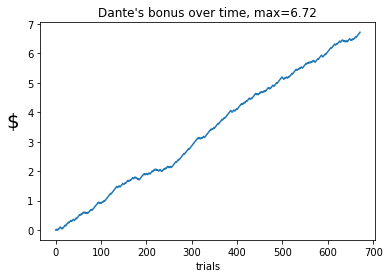

In [607]:

ylabel('$   ', fontsize=20, rotation=0)
xlabel('trials')
title("%s's bonus over time, max=%.02f"%(checking_manually['name'], max_bonus))
plot(subject_bonus); 


In [637]:
import json
with open('../support/bird_data.json') as f:
    bird_info = json.load(f)
bird_info['clusters']

[[164,
  37,
  138,
  133,
  173,
  139,
  115,
  34,
  156,
  16,
  157,
  15,
  53,
  147,
  42,
  135,
  14,
  41,
  55,
  13],
 [116,
  170,
  119,
  128,
  98,
  118,
  117,
  124,
  120,
  130,
  126,
  103,
  129,
  38,
  148,
  132,
  149,
  36,
  127,
  114],
 [174,
  168,
  166,
  171,
  179,
  160,
  169,
  176,
  19,
  161,
  95,
  181,
  155,
  97,
  54,
  199,
  167,
  46,
  175,
  162],
 [48,
  111,
  12,
  81,
  39,
  78,
  150,
  110,
  137,
  101,
  79,
  159,
  26,
  10,
  113,
  77,
  90,
  18,
  102,
  8],
 [141,
  63,
  144,
  145,
  60,
  57,
  70,
  64,
  143,
  140,
  142,
  58,
  1,
  7,
  83,
  65,
  44,
  59,
  146,
  61]]

In [632]:
path_to_tasks  = '..'

ls 

In [608]:
[i for i in os.listdir('compensation_records/') if checking_manually['worker_id'] in i]

[]

In [610]:
compensate_worker(checking_manually['worker_id'], amazon['Assignment ID'].values[0], max_bonus-.50)

AZKH6G2SIV9S: already accepted compensation HIT,  
working on a compensation HIT for AZKH6G2SIV9S
no feedback data for subject

Enter a custom message? Pressing enter reverts to default. Sorry for the delay!
Amount to bonus worker? Pressing enter reverts to 6.72 
success!



In [465]:
def compensate_worker(worker_id, assignment_id, bonus_amount):   

    try: 
        mtc.approve_assignment(assignment_id)
        print('%s: accepted compensation HIT, '%worker_id, end=' ')
    except: 
        print('%s: already accepted compensation HIT, '%worker_id, end=' ')

    base_pay = 0.50
    bonus_amount = bonus_amount + base_pay

    directory = 'compensation_records'

    if not os.path.exists(directory): os.makedirs(directory)

    if not os.path.exists(directory + '/' + worker_id + '_' + assignment_id + '_' + str(bonus_amount) + '.npy'):

        print('\nworking on a compensation HIT for %s'%worker_id)

        try: 
            print('n trials:', w_data['n_trials'])
            print('duration:', w_data['experiment_duration'])
            print('blocks_completed:', w_data['n_block'])
            print('total_bonus_earned:', w_data['total_bonus_earned'])
            print(w_data['worker_input'])

        except: 

            print("no feedback data for subject\n")

        bonus_amount = bonus_amount 

        MSG = input("Enter a custom message? Pressing enter reverts to default. ")
        if len(MSG) == 0: MSG = "Thanks so much for participating in our study!"
        BONUS = input("Amount to bonus worker? Pressing enter reverts to {} ".format(bonus_amount))
        if len(BONUS) == 0: BONUS = bonus_amount
        converted_bonus = boto.mturk.price.Price(BONUS) 

        s = mtc.grant_bonus(worker_id, assignment_id,  converted_bonus, MSG);
        print('success!\n')

        compensation_info = {'time':datetime.datetime.now(), 
                             'worker_id': worker_id, 
                             'message':MSG, 
                             'bonus_amount':bonus_amount,
                             'assignment_id':assignment_id, 
                             'submission_response':{type(s): s}, 
                             'worker_data':w_data}    

        np.save(directory + '/' + worker_id + '_' + assignment_id + '_' + str(bonus_amount), compensation_info)

    else: 

        print('already bonused for the original HIT')